# RFI Report

## Section 0: Creating the Injections Databases

In [ ]:
import requests
import json
import time
import datetime
import random

injections_list = []
json_list=[]
uuid_list = []
for n in range(0,1000):
    
    x = datetime.datetime.utcnow() + datetime.timedelta(minutes=5)
    t=x.strftime('%Y')+'-'+x.strftime('%m')+'-'+x.strftime('%d')+'T'+x.strftime('%H')+':'+x.strftime('%M')+':'+x.strftime('%S')+'.'+x.strftime('%f')+'Z'
    print(t)
    
    injections_list.append({
    "timeout_sec": 7200,
    "injection_program": "injections_0806d",
    "injection_program_id": "test",
    "ra": 0.0,
    "dec": 0.0,
    "beam_x": 0.0,
    "beam_y": 0.0,
    "beam_no": 1127,
    "dm": 700,
    "tau_1_ghz_ms": 1.0,
    "pulse_width_ms": 1.0,
    "snr": 0.0,
    "fluence_jy_ms": random.uniform(0.5,10),
    "spindex": 0.0,
    "running": 0.0,
    "injection_time": t,
    "gaussian_central_freq": 0.0,
    "gaussian_fwhm": 0.0,
    "plot": False,
    "conserve_fluence": True,
    "apply_beam_model": True,
    "apply_fluence_pipeline_calibration": False,
    "apply_calibration_factor": True,
    "sample_beam": False,
    "use_ra_dec": False,
    "use_manual_xy": True,
    "use_empirical_spectral_model": True,
    "use_gaussian_spectral_model": False,}
    )
    
    json_list.append(json.dumps(injections_list[n]))
    inject = requests.post(url = 'http://localhost:8220/generate-pulse', data = json_list[n])
    uuid_list.append(inject.json())
    print(inject.status_code)
    time.sleep(5)
    
    delete = requests.delete('http://localhost:8001/v2/mimic/87376251-051f-4bb4-b97e-6211ca7c2aea')
    print(delete.text)

## Section I: Downloading the Dataset

In [1]:
from codefile import *

In [2]:
resp = requests.get("http://localhost:8001/v2/mimic/injection/program/200813_flat_alpha.h5")
data = extract_injections(resp)
detected_mask = np.logical_and.reduce((data.combined_snr.values > 8.0, data.rfi_grade_level2.values > 7.0)) #I think this makes sense? Though threshold changed over time
det = data[detected_mask]
print(data.keys())

Injections shape: (84697, 16)
Detections shape: (39638, 38)
Index(['active', 'bandwidth', 'beams', 'dec', 'dm_inj', 'expiration_time',
       'fluence_jy_ms', 'id_inj', 'injection_program', 'injection_program_id',
       'injection_time', 'pulse_width_ms_inj', 'ra', 'timeout_sec',
       'timestamp_fpga', 'beam_activity', 'beam_sensitivity',
       'beam_sensitivity_max_95', 'beam_sensitivity_min_95', 'combined_snr',
       'dead_beam_nos', 'det_id', 'dm_det', 'dm_error', 'dm_gal_ne_2001_max',
       'dm_gal_ymw_2016_max', 'event_category', 'event_processing_start_time',
       'event_status', 'flux_mjy', 'flux_mjy_max_95', 'flux_mjy_min_95',
       'id_det', 'is_test', 'known_source_name', 'known_source_rating',
       'l1_events', 'pos_dec_deg', 'pos_error_semimajor_deg_68',
       'pos_error_semimajor_deg_95', 'pos_error_semiminor_deg_68',
       'pos_error_semiminor_deg_95', 'pos_error_theta_deg_68',
       'pos_error_theta_deg_95', 'pos_ra_deg', 'pulse_width_ms_det',
       'rfi_g

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
data = data.assign(avg_l1_rfi_grade=0.0)
for i in range(len(data)):
    temp = data.l1_events[i]
    if isinstance(temp, list):
        # use data.info to find that the column number for avg_l1_rfi_grade is 70
        data.iat[i, 70] = temp[0]['rfi_grade_level1']
    else:
        data.iat[i, 70] = np.nan

## Section II: Describing the Data

In [4]:
data.describe()

,bandwidth,dec,dm_inj,expiration_time,fluence_jy_ms,injection_program_id,pulse_width_ms_inj,ra,timeout_sec,timestamp_fpga,...,band_averaged_sensitivity,beam_x,beam_y,gaussian_central_freq,gaussian_fwhm,snr_radiometer,spectral_index,spectral_running,tau_1_ghz_ms,avg_l1_rfi_grade
count,84697.0,84697.0,84697.000000,8.469700e+04,84697.000000,8.469700e+04,84697.000000,84697.0,84697.0,8.469700e+04,...,8.469700e+04,84697.000000,84697.000000,84697.0,84697.0,8.469700e+04,84697.000000,84697.000000,84697.000000,39638.000000
mean,0.0,0.0,720.531023,1.598503e+09,100.094413,2.496144e+06,2.878988,0.0,600.0,3.425842e+11,...,2.583078e-01,-0.163458,-0.863474,0.0,0.0,4.199824e+03,7.878916,-27.960152,0.354751,9.814219
std,0.0,0.0,780.475125,1.346304e+06,3095.811327,1.441997e+06,9.199800,0.0,0.0,8.756538e+10,...,2.226275e-01,1.695820,26.405667,0.0,0.0,1.152427e+05,12.517478,35.333153,1.263642,1.062470
min,0.0,0.0,0.052993,1.597370e+09,0.382297,7.000000e+00,0.002263,0.0,600.0,3.199743e+10,...,1.530000e-08,-13.953125,-60.750000,0.0,0.0,6.133262e-04,-14.441769,-257.029742,0.000019,0.000000
25%,0.0,0.0,278.208545,1.597558e+09,3.100021,1.247012e+06,0.490907,0.0,600.0,2.728237e+11,...,7.012735e-02,-0.654785,-20.906250,0.0,0.0,2.978916e+02,-0.585994,-44.446091,0.016084,10.000000
50%,0.0,0.0,472.051518,1.597685e+09,7.028015,2.492357e+06,0.969694,0.0,600.0,3.558963e+11,...,1.888752e-01,0.001224,-0.919434,0.0,0.0,5.971444e+02,4.264095,-12.648948,0.055219,10.000000
75%,0.0,0.0,823.356073,1.600440e+09,20.311216,3.747839e+06,1.949359,0.0,600.0,3.855955e+11,...,4.125613e-01,0.665527,18.781250,0.0,0.0,1.376038e+03,13.041326,-4.282525,0.185398,10.000000
max,0.0,0.0,14754.772662,1.600866e+09,525496.112496,4.999987e+06,99.908806,0.0,600.0,5.417025e+11,...,9.974111e-01,8.125000,61.187500,0.0,0.0,1.645212e+07,96.485328,16.252521,44.806506,10.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84697 entries, NaT to NaT
Data columns (total 71 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   active                              84697 non-null  bool          
 1   bandwidth                           84697 non-null  int64         
 2   beams                               84697 non-null  object        
 3   dec                                 84697 non-null  int64         
 4   dm_inj                              84697 non-null  float64       
 5   expiration_time                     84697 non-null  float64       
 6   fluence_jy_ms                       84697 non-null  float64       
 7   id_inj                              84697 non-null  object        
 8   injection_program                   84697 non-null  object        
 9   injection_program_id                84697 non-null  int64         
 10  injection_time     

In [6]:
injections = data
detections = injections.dropna(how='any')
l1_pass = detections[detections['avg_l1_rfi_grade']>= 5]
l2_pass = l1_pass[l1_pass['rfi_grade_level2'] >= 7]
print('inejctions:', injections.shape)
print('detections:', detections.shape)
print('l1_pass:', l1_pass.shape)
print('l2_pass:', l2_pass.shape)

inejctions: (84697, 71)
detections: (39638, 71)
l1_pass: (39161, 71)
l2_pass: (35798, 71)


##### 42% of the injected pulses are finally detected
##### Drop percentage from Bonsai to L1= 1.22%
##### Drop percentage from L1 to L2= 8.58%

## Section III: The Plotting Functions

### 1. Detection Fraction: plot_detection_fraction

Makes a detection fraction histogram of FRBs detected as a function of x_parameter at bonsai, L1, and L2.The filtered dataset is passed as a pandas data frame or a numpy record array and x_parameter must be a valid column name data frame. 
    
The x_range can be specified as [x_min, x_max]. 
If x_range is None, then we use the min and max of the x_parameter in the dataset.
x_bins specifies the number of bins to split the x axis into.

Input parameters: 

filtered_dataset: dataset to be considered for plotting

l1_cutoff: cutoff average RFI L1 score; default: 5

l2_cutoff: cutoff average RFI L2 score; default: 7

x_parameter: observable plotted on the x-axis; default: "fluence_jy_ms"

x_range: specifies the range of the x-parameter to be plotted; default: full range

x_bins: specifies number of bins to be used for calculating the detection fraction; default: 10

x_log: (True/False), applies a log scale on the x-axis; default: False

#### Sample Plot

bins: [1.00000000e+00 2.78255940e+00 7.74263683e+00 2.15443469e+01
 5.99484250e+01 1.66810054e+02 4.64158883e+02 1.29154967e+03
 3.59381366e+03 1.00000000e+04]
Injections Hist: [16922 26207 19691 10791  5119  2587  1112   450   172]
Bonsai Hist: [ 4050 11097 10942  7009  3456  1595   809   380   159]
L1 Hist: [ 3996 10994 10851  6936  3414  1544   771   362   155]
L2 Hist: [ 3736 10292 10018  6148  3004  1368   656   318   137]
DF at Bonsai: [0.23933341 0.42343649 0.55568534 0.64952275 0.67513186 0.61654426
 0.72751799 0.84444444 0.9244186 ]
DF at L1: [0.2361423  0.41950624 0.55106394 0.64275785 0.66692713 0.59683031
 0.69334532 0.80444444 0.90116279]
DF at L2 [0.22077769 0.3927195  0.50876035 0.56973404 0.58683337 0.52879784
 0.58992806 0.70666667 0.79651163]


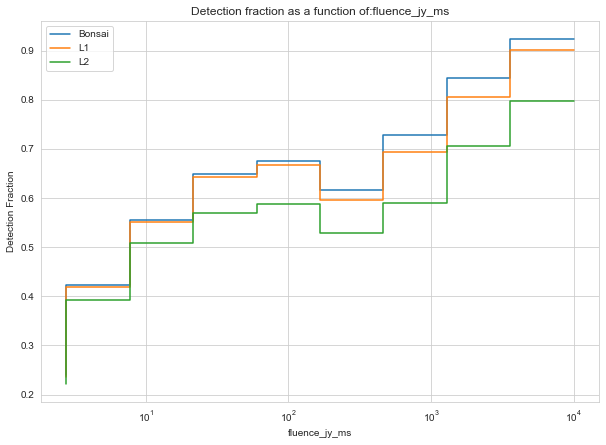

In [7]:
plot_detection_fraction(data, 5, 7, x_parameter = 'fluence_jy_ms', x_bins= 10, x_range=[1,10000],  x_log =True)

### 2. SNR-Fluence Ratio: plot_snr_fluence_ratio

Makes a detection fraction histogram of FRBs detected as a function of x_parameter at bonsai, L1, and L2.The filtered dataset is passed as a pandas data frame or a numpy record array and x_parameter must be a valid column name data frame. The x_range can be specified as [x_min, x_max]. 
    
    
If x_range is None, then we use the min and max of the x_parameter in the dataset.

Input parameters: 

filtered_dataset: dataset to be considered for plotting

l1_cutoff: cutoff average RFI L1 score; default: 5

l2_cutoff: cutoff average RFI L2 score; default: 7

x_parameter: observable plotted on the x-axis; default: "fluence_jy_ms"

x_range: specifies the range of the x-parameter to be plotted; default: full range

x_bins: specifies number of bins to be used for calculating the detection fraction; default: 10

x_log: (True/False), applies a log scale on the x-axis; default: False

#### Sample Plot

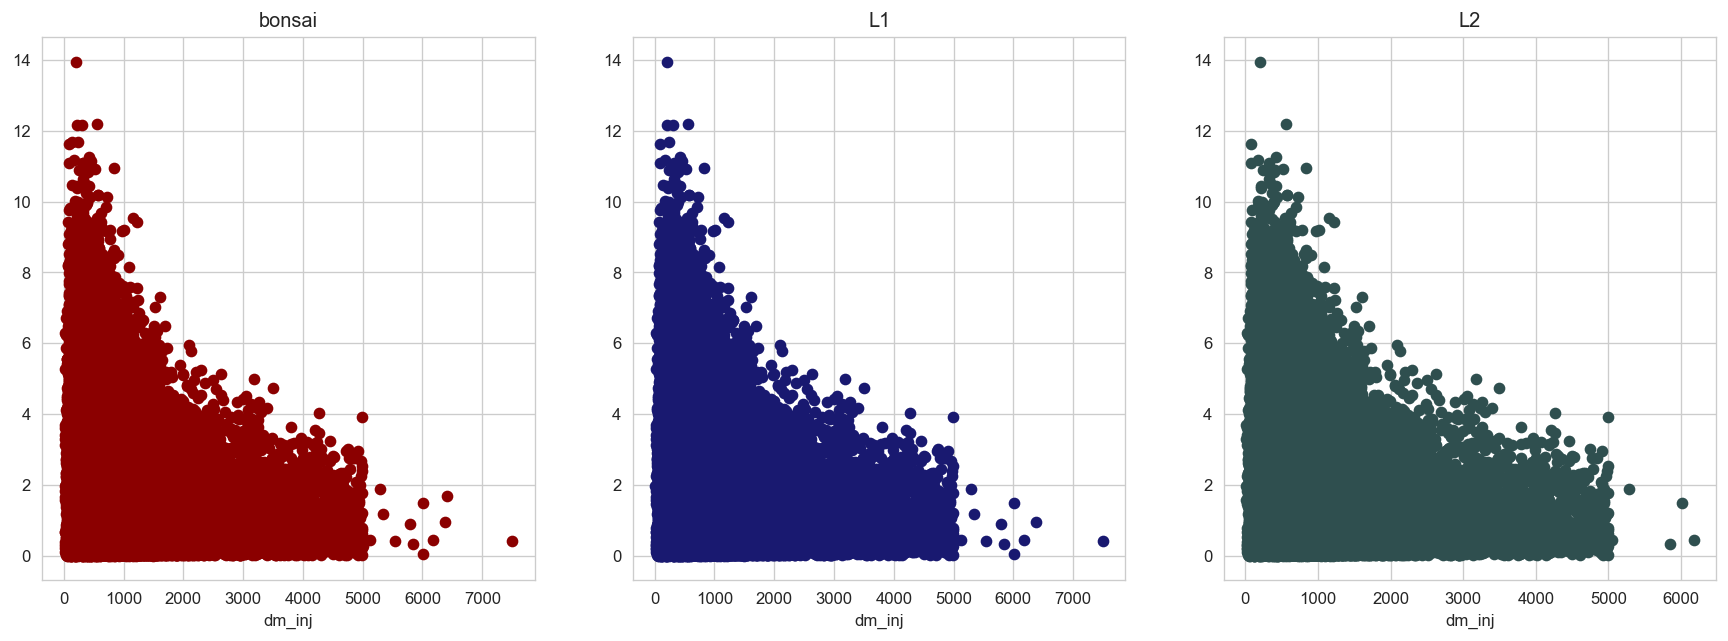

In [8]:
plot_snr_fluence_ratio(data, 5, 7, 'dm_inj', x_log=False)

### 3. Detection Histograms: plot_detection_histograms

Makes a histogram of FRBs detected as a function of x_parameter at bonsai, L1, and L2. The filtered dataset is passed as a pandas data frame or a numpy record array and x_parameter must be a valid column name data frame. The x_range can be specified as [x_min, x_max]. 

If x_range is None, then we use the min and max of the x_parameter in the dataset.
x_bins specifies the number of bins to split the x axis into.

Input parameters: 

filtered_dataset: dataset to be considered for plotting

l1_cutoff: cutoff average RFI L1 score; default: 5

l2_cutoff: cutoff average RFI L2 score; default: 7

x_parameter: observable plotted on the x-axis; default: "fluence_jy_ms"

x_range: specifies the range of the x-parameter to be plotted; default: full range

x_bins: specifies number of bins to be used for calculating the detection fraction; default: 10

x_log: (True/False), applies a log scale on the x-axis; default: False

#### Sample Plot

bins: [1, 1.000009999, 1.00009999, 1.0009999, 1.009999, 1.09999, 1.9999, 10.999, 100.99, 1000.9, 10000.0]
bins: [1.00000000e+00 1.00001000e+00 1.00009999e+00 1.00099990e+00
 1.00999900e+00 1.09999000e+00 1.99990000e+00 1.09990000e+01
 1.00990000e+02 1.00090000e+03 1.00000000e+04]
Injections Hist: [    0     0     6    67   639  8575 41789 25563  5603   809]
Bonsai Hist: [    0     0     0     7    68  1630 17608 15832  3667   685]
L1 Hist: [    0     0     0     7    66  1605 17446 15680  3565   654]
L2 Hist: [    0     0     0     6    61  1503 16299 14130  3109   569]


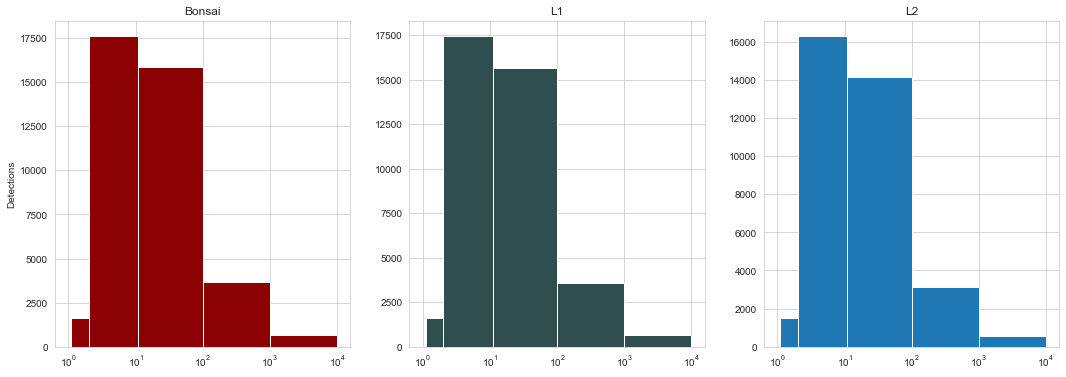

In [9]:
plot_detection_histograms(data,5,7, x_parameter = 'fluence_jy_ms', x_range = [1,10000], x_bins=10, x_log = True)

## Section 4: Univariate Analysis

### 4.1 Detection Fraction Plots

#### 4.1.1 Detection Fraction vs Fluence

bins: [1.00000000e+00 2.78255940e+00 7.74263683e+00 2.15443469e+01
 5.99484250e+01 1.66810054e+02 4.64158883e+02 1.29154967e+03
 3.59381366e+03 1.00000000e+04]
Injections Hist: [16922 26207 19691 10791  5119  2587  1112   450   172]
Bonsai Hist: [ 4050 11097 10942  7009  3456  1595   809   380   159]
L1 Hist: [ 3996 10994 10851  6936  3414  1544   771   362   155]
L2 Hist: [ 3736 10292 10018  6148  3004  1368   656   318   137]
DF at Bonsai: [0.23933341 0.42343649 0.55568534 0.64952275 0.67513186 0.61654426
 0.72751799 0.84444444 0.9244186 ]
DF at L1: [0.2361423  0.41950624 0.55106394 0.64275785 0.66692713 0.59683031
 0.69334532 0.80444444 0.90116279]
DF at L2 [0.22077769 0.3927195  0.50876035 0.56973404 0.58683337 0.52879784
 0.58992806 0.70666667 0.79651163]


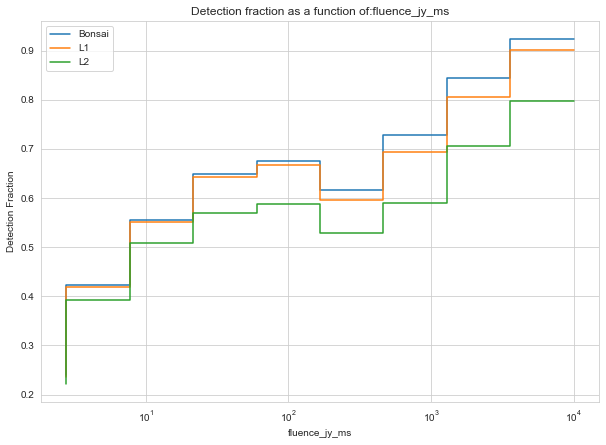

In [10]:
plot_detection_fraction(data, 5, 7, x_parameter = 'fluence_jy_ms', x_bins= 10, x_range=[1,10000],  x_log =True)

##### Percentage of pulses going through L2 is lower at high fluence values ~1000 onwards; DF increases continously with increase in fluence value (approaching 1 beyond 100,000)

#### 4.1.2 Detection Fraction vs DM

bins: [   10.            21.5443469     46.41588834   100.
   215.443469     464.15888336  1000.          2154.43469003
  4641.58883361 10000.        ]
Injections Hist: [   26   147  1835 11310 28352 27199 11025  4349   439]
Bonsai Hist: [    8    55   775  4893 12995 13292  5470  1969   181]
L1 Hist: [    8    55   766  4833 12843 13144  5410  1928   174]
L2 Hist: [    7    49   704  4376 11766 12093  4957  1717   129]
DF at Bonsai: [0.30769231 0.37414966 0.42234332 0.43262599 0.45834509 0.48869444
 0.49614512 0.45274776 0.41230068]
DF at L1: [0.30769231 0.37414966 0.41743869 0.42732095 0.45298392 0.48325306
 0.49070295 0.4433203  0.39635535]
DF at L2 [0.26923077 0.33333333 0.38365123 0.38691424 0.41499718 0.44461193
 0.44961451 0.3948034  0.29384966]


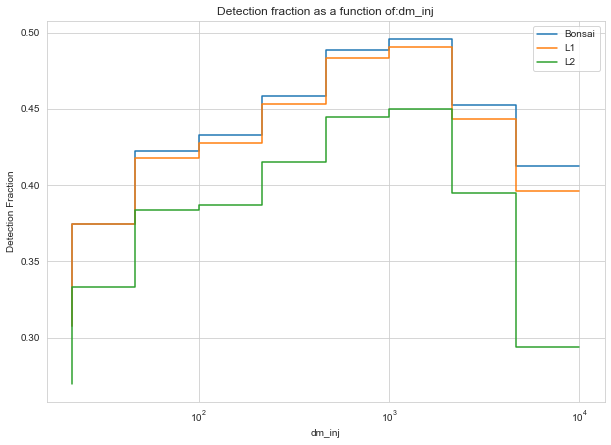

In [11]:
plot_detection_fraction(data, 5, 7, x_parameter = 'dm_inj', x_range =[10,10000] ,x_log =True) #10,10000

##### Maximum detection rates lie between DM = 10 and DM = 3,500, beyond which pulses passing L1, L2 and Bonsai dropped

#### 4.1.3 Detection Fraction vs Scattering Time

bins: [1.86701000e-05 9.55118235e-05 4.88615938e-04 2.49964377e-03
 1.27875874e-02 6.54182777e-02 3.34664463e-01 1.71206438e+00
 8.75851713e+00 4.48065057e+01]
Injections Hist: [   39   511  3583 13792 27641 25616  9980  2959   575]
Bonsai Hist: [   16   287  1899  7351 13888 11459  3850   790    98]
L1 Hist: [   16   284  1890  7306 13761 11348  3736   728    92]
L2 Hist: [   16   268  1761  6755 12700 10498  3296   466    38]
DF at Bonsai: [0.41025641 0.56164384 0.53000279 0.53299014 0.50244202 0.4473376
 0.38577154 0.26698209 0.17043478]
DF at L1: [0.41025641 0.55577299 0.52749093 0.52972738 0.4978474  0.44300437
 0.3743487  0.24602906 0.16      ]
DF at L2 [0.41025641 0.52446184 0.49148758 0.48977668 0.45946239 0.40982199
 0.33026052 0.15748564 0.06608696]


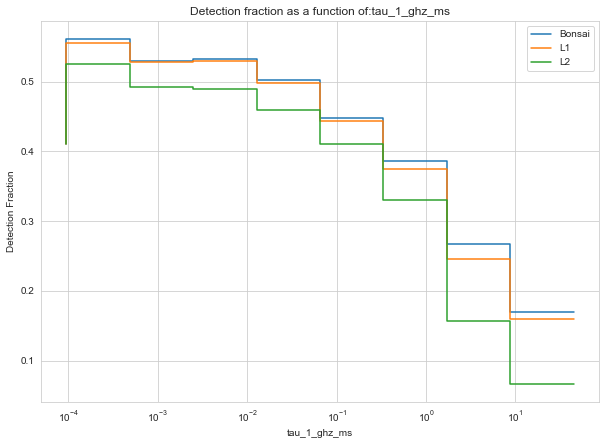

In [12]:
plot_detection_fraction(data, 5, 7, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_log =True)

##### Least scattering times have the highest detection rates; Very low DFs are seen beyond a scattering time of 1ms

#### 4.1.4 Detection Fraction vs Pulse Width

bins: [  0.1          0.21544347   0.46415888   1.           2.15443469
   4.64158883  10.          21.5443469   46.41588834 100.        ]
Injections Hist: [ 4684 13933 23669 22631 11832  3772  1047   844  1193]
Bonsai Hist: [ 2139  6463 11203 10794  5671  1696   466   346   353]
L1 Hist: [ 2120  6394 11085 10674  5603  1676   456   331   323]
L2 Hist: [ 1972  5903 10226  9859  5162  1552   401   201    68]
DF at Bonsai: [0.45666097 0.46386277 0.47331953 0.47695639 0.47929344 0.44962884
 0.44508118 0.40995261 0.29589271]
DF at L1: [0.45260461 0.4589105  0.46833411 0.47165393 0.47354632 0.44432662
 0.43553009 0.39218009 0.27074602]
DF at L2 [0.42100769 0.42367042 0.43204191 0.43564138 0.43627451 0.41145281
 0.38299904 0.23815166 0.05699916]


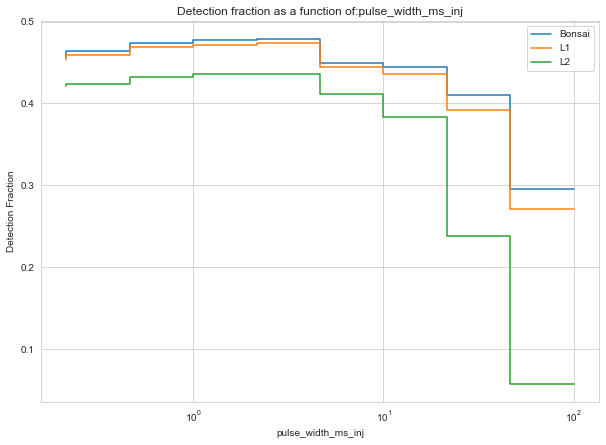

In [13]:
plot_detection_fraction(data, 5, 7, x_parameter = 'pulse_width_ms_inj', x_range = [0.1,100],x_bins= 10,  x_log =True)

##### Very low DFs are observed beyond a pulse width value of ~30; low pulse widths correspond to high detection rate at L1,L2 and Bonsai

### 4.2 SNR-Fluence Ratio Plots

#### 4.2.2 SNR-Fluence Ratio vs DM

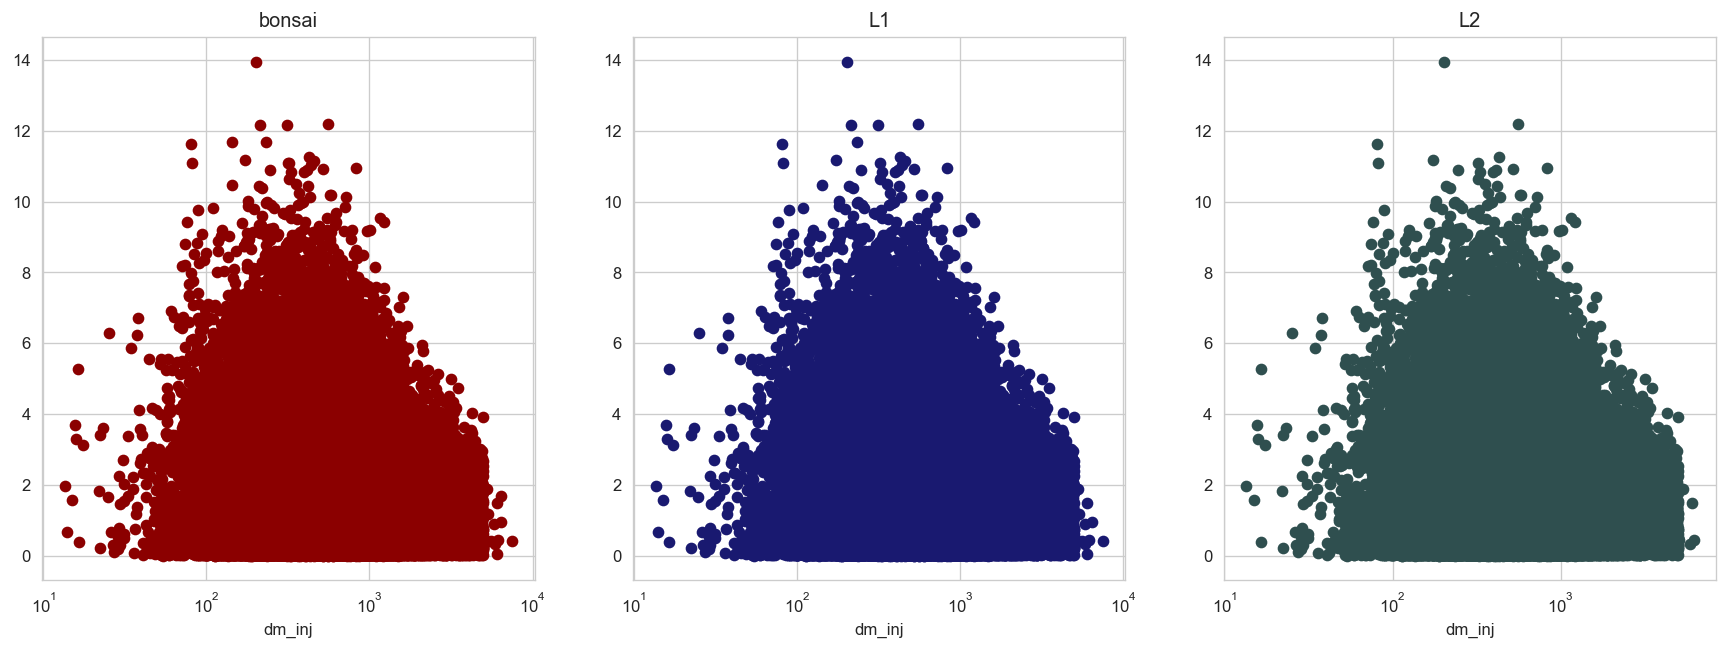

In [16]:
plot_snr_fluence_ratio(data, 5, 7, 'dm_inj', x_log=True)

##### The ratio increases with increase in the DM value till ~500 and decreases continously thereafter

#### 4.2.3 SNR-Fluence Ratio vs Scattering Time

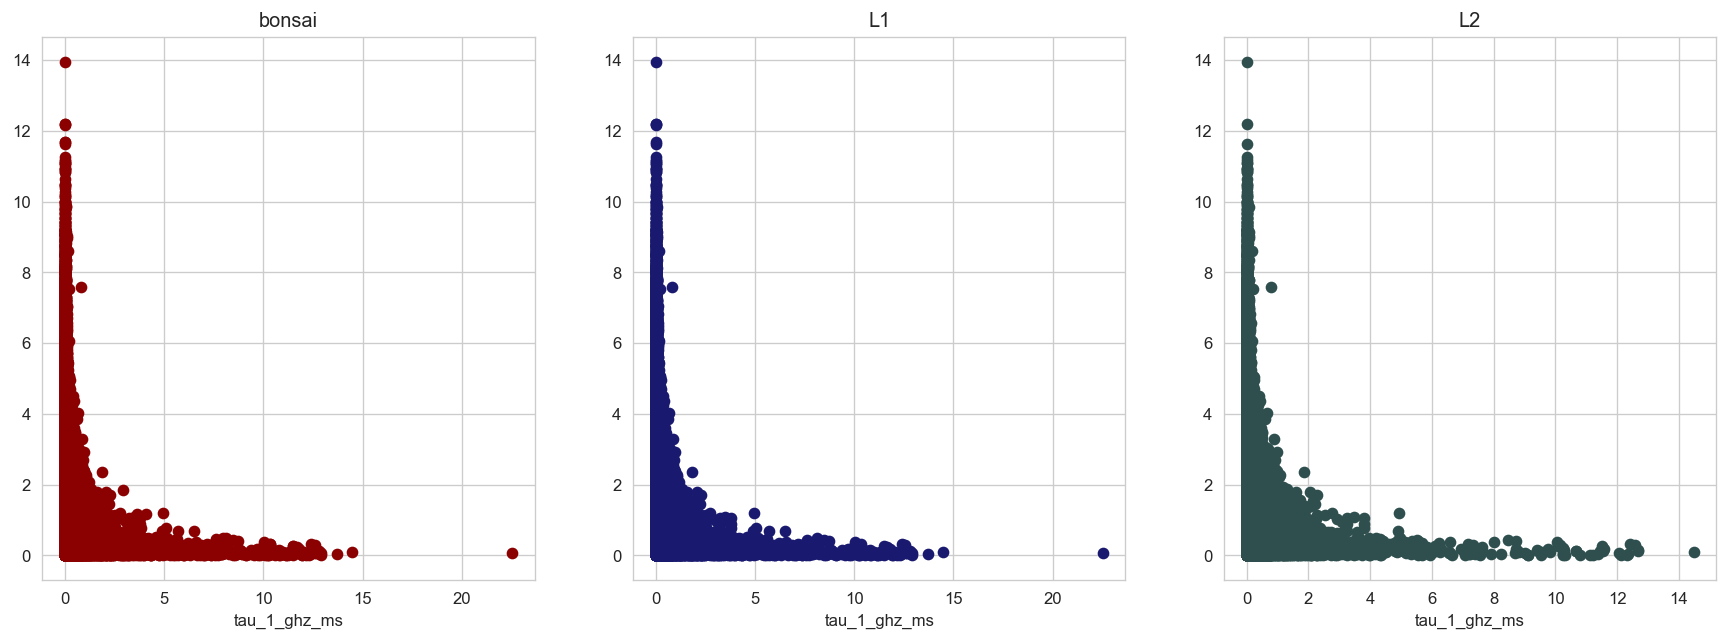

In [17]:
plot_snr_fluence_ratio(data, 5, 7, 'tau_1_ghz_ms',  x_log=False)

#### 4.2.4 SNR-Fluence Ratio vs Pulse Width

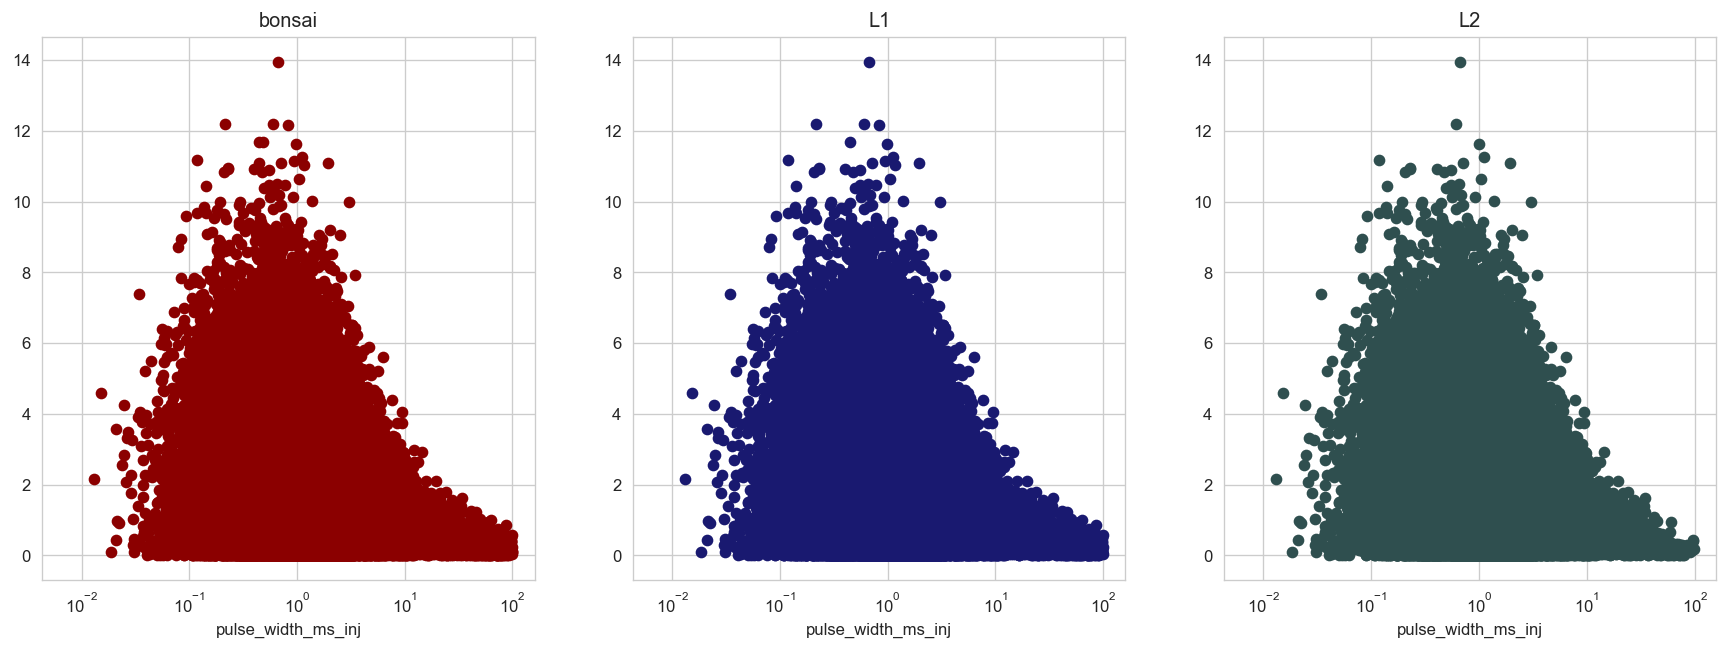

In [18]:
plot_snr_fluence_ratio(data, 5, 7, 'pulse_width_ms_inj', x_log=True)

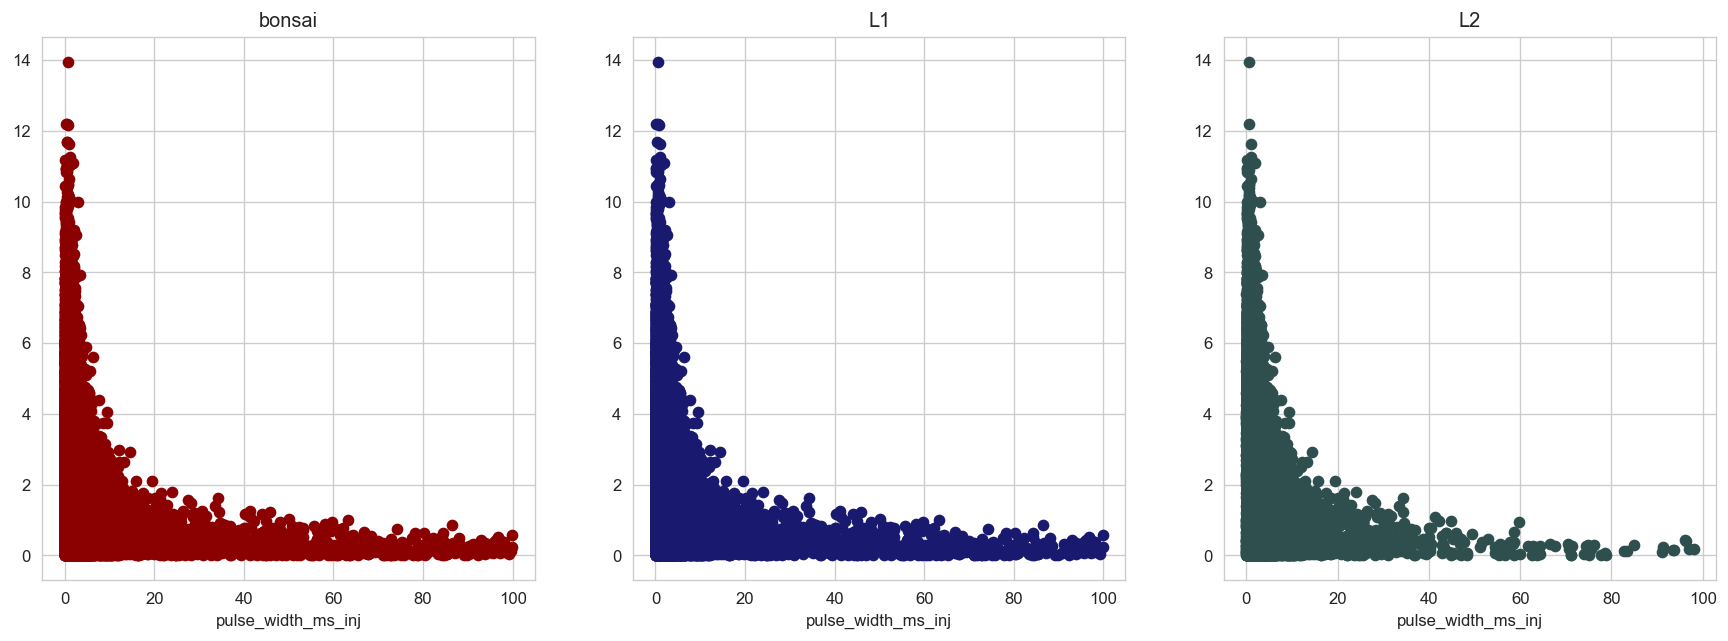

In [19]:
plot_snr_fluence_ratio (data, 5, 7, 'pulse_width_ms_inj', x_log = False)

##### When plotted on a logarithmic axis, the ratio increases and then decreases as the pulse width hits a value of 1

## Section 5: Multivariate Analysis

### 5.1 Detection Fractions with DM Segmentation

In [20]:
dm_set1 = injections[injections['dm_inj']<=300]
dm_set2 = injections[injections['dm_inj'].between(300,1000)]
dm_set3 = injections[injections['dm_inj']>=1000]

#### 5.1.1 DF vs Pulse Width

bins: [9.12813360e-03 2.56477863e-02 7.20639039e-02 2.02481656e-01
 5.68923120e-01 1.59853254e+00 4.49147907e+00 1.26199397e+01
 3.54588934e+01 9.96306758e+01]
Injections Hist: [   5  114 1404 5810 9488 5279 1217  297  387]
Bonsai Hist: [   4   50  595 2537 4282 2353  510  135  103]
L1 Hist: [   4   49  591 2510 4236 2327  505  130   98]
L2 Hist: [   3   46  546 2304 3890 2108  455  103   10]
DF at Bonsai: [0.8        0.43859649 0.42378917 0.43666093 0.45130691 0.44572836
 0.41906327 0.45454545 0.26614987]
DF at L1: [0.8        0.42982456 0.42094017 0.43201377 0.44645868 0.44080318
 0.41495481 0.43771044 0.25322997]
DF at L2 [0.6        0.40350877 0.38888889 0.39655766 0.40999157 0.39931805
 0.37387017 0.34680135 0.02583979]


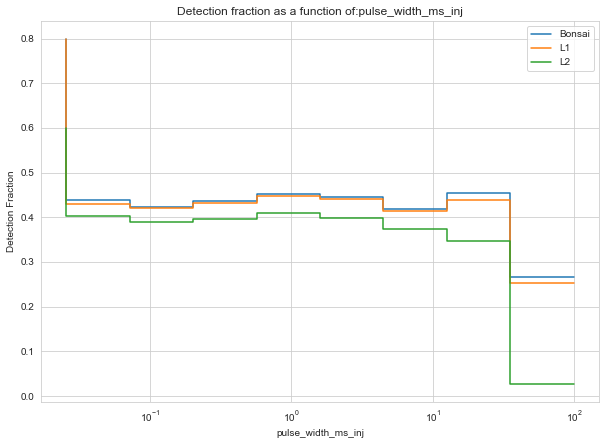

bins: [2.26345900e-03 7.42788174e-03 2.43757131e-02 7.99925752e-02
 2.62507688e-01 8.61458530e-01 2.82700596e+00 9.27724600e+00
 3.04446805e+01 9.99088063e+01]
Injections Hist: [    0     7   317  4098 15957 17522  5301   797   880]
Bonsai Hist: [   0    4  150 1949 7612 8574 2497  364  299]
L1 Hist: [   0    4  149 1924 7547 8476 2467  359  273]
L2 Hist: [   0    4  135 1763 6914 7782 2291  301   64]
DF at Bonsai: [       nan 0.57142857 0.47318612 0.47559785 0.47703202 0.4893277
 0.4710432  0.45671267 0.33977273]
DF at L1: [       nan 0.57142857 0.47003155 0.46949732 0.47295858 0.48373473
 0.46538389 0.45043915 0.31022727]
DF at L2 [       nan 0.57142857 0.42586751 0.43020986 0.43328947 0.44412738
 0.43218261 0.37766625 0.07272727]


C:\Users\Hp\Desktop\TIFR Internship\codefile.py:273: RuntimeWarning: invalid value encountered in true_divide
  df_bonsai = np.divide(hist_detections, hist_injections)
C:\Users\Hp\Desktop\TIFR Internship\codefile.py:274: RuntimeWarning: invalid value encountered in true_divide
  df_l1 = np.divide(hist_l1, hist_injections)
C:\Users\Hp\Desktop\TIFR Internship\codefile.py:275: RuntimeWarning: invalid value encountered in true_divide
  df_l2 = np.divide(hist_l2, hist_injections)


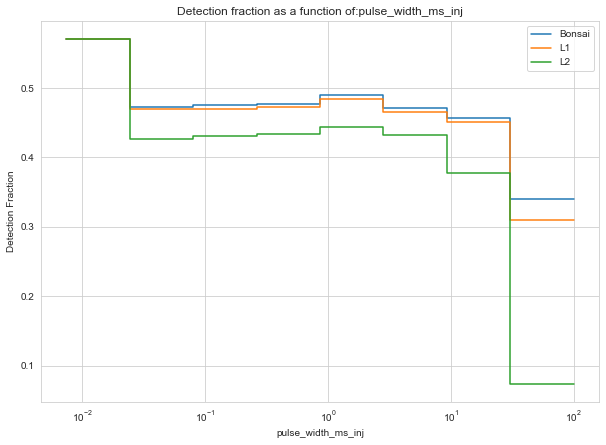

bins: [5.67173970e-03 1.68059957e-02 4.97980350e-02 1.47557118e-01
 4.37228156e-01 1.29555567e+00 3.83887558e+00 1.13750154e+01
 3.37054362e+01 9.98729572e+01]
Injections Hist: [   0   35  444 2705 6028 4703 1260  285  354]
Bonsai Hist: [   0   15  207 1277 2956 2327  605  128  105]
L1 Hist: [   0   15  207 1256 2916 2300  598  124   96]
L2 Hist: [   0   15  184 1121 2598 2042  544  100   34]
DF at Bonsai: [       nan 0.42857143 0.46621622 0.47208872 0.49037823 0.49479056
 0.48015873 0.44912281 0.29661017]
DF at L1: [       nan 0.42857143 0.46621622 0.46432532 0.48374253 0.48904954
 0.47460317 0.43508772 0.27118644]
DF at L2 [       nan 0.42857143 0.41441441 0.41441774 0.43098872 0.43419094
 0.43174603 0.35087719 0.0960452 ]


C:\Users\Hp\Desktop\TIFR Internship\codefile.py:273: RuntimeWarning: invalid value encountered in true_divide
  df_bonsai = np.divide(hist_detections, hist_injections)
C:\Users\Hp\Desktop\TIFR Internship\codefile.py:274: RuntimeWarning: invalid value encountered in true_divide
  df_l1 = np.divide(hist_l1, hist_injections)
C:\Users\Hp\Desktop\TIFR Internship\codefile.py:275: RuntimeWarning: invalid value encountered in true_divide
  df_l2 = np.divide(hist_l2, hist_injections)


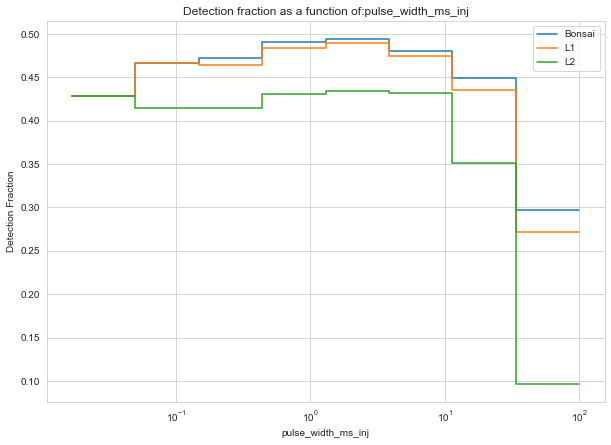

In [21]:
plot_detection_fraction(dm_set1, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(dm_set2, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(dm_set3, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)

##### Analysis: DFs at L2 are maximum in the injections with DMs ranging from 300 to 1000. 

#### 5.1.2 DF vs Scattering Time

bins: [1.86701000e-05 9.55118235e-05 4.88615938e-04 2.49964377e-03
 1.27875874e-02 6.54182777e-02 3.34664463e-01 1.71206438e+00
 8.75851713e+00 4.48065057e+01]
Injections Hist: [  14  164 1082 4109 7928 7109 2657  789  149]
Bonsai Hist: [   6   81  560 1998 3695 3071  961  179   18]
L1 Hist: [   6   80  556 1984 3656 3045  938  169   16]
L2 Hist: [   6   78  517 1833 3338 2785  804   96    8]
DF at Bonsai: [0.42857143 0.49390244 0.51756007 0.4862497  0.46606963 0.43198762
 0.36168611 0.22686946 0.12080537]
DF at L1: [0.42857143 0.48780488 0.51386322 0.48284254 0.46115035 0.42833029
 0.35302973 0.21419518 0.10738255]
DF at L2 [0.42857143 0.47560976 0.47781885 0.44609394 0.42103935 0.39175693
 0.30259691 0.121673   0.05369128]


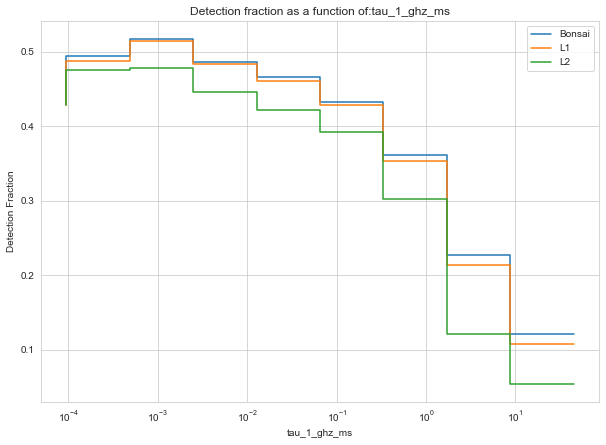

bins: [2.05303000e-05 1.02388635e-04 5.10632213e-04 2.54662305e-03
 1.27005089e-02 6.33399299e-02 3.15888660e-01 1.57539873e+00
 7.85682262e+00 3.91835162e+01]
Injections Hist: [   20   274  1933  7240 14544 13599  5318  1570   381]
Bonsai Hist: [   9  152 1049 3979 7487 6137 2102  455   79]
L1 Hist: [   9  150 1046 3958 7418 6085 2038  424   71]
L2 Hist: [   8  142  966 3631 6787 5615 1816  266   23]
DF at Bonsai: [0.45       0.55474453 0.54267977 0.54958564 0.51478273 0.45128318
 0.39526138 0.28980892 0.20734908]
DF at L1: [0.45       0.54744526 0.54112778 0.54668508 0.5100385  0.44745937
 0.38322678 0.27006369 0.18635171]
DF at L2 [0.4        0.51824818 0.49974133 0.50151934 0.46665292 0.41289801
 0.34148176 0.16942675 0.06036745]


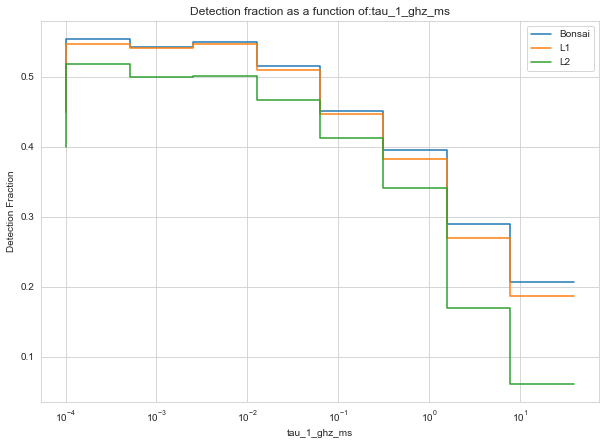

bins: [3.14765000e-05 1.40825315e-04 6.30050014e-04 2.81883282e-03
 1.26114091e-02 5.64232256e-02 2.52436532e-01 1.12939666e+00
 5.05290106e+00 2.26065917e+01]
Injections Hist: [  10  120  666 2212 4412 4734 2585  803  271]
Bonsai Hist: [   4   77  338 1257 2344 2229 1051  266   54]
L1 Hist: [   4   76  337 1247 2326 2202 1024  247   49]
L2 Hist: [   3   65  299 1093 2076 1984  894  203   21]
DF at Bonsai: [0.4        0.64166667 0.50750751 0.56826401 0.53127833 0.47084918
 0.4065764  0.33125778 0.19926199]
DF at L1: [0.4        0.63333333 0.50600601 0.56374322 0.52719855 0.46514575
 0.39613153 0.30759651 0.18081181]
DF at L2 [0.3        0.54166667 0.44894895 0.49412297 0.4705349  0.4190959
 0.34584139 0.25280199 0.07749077]


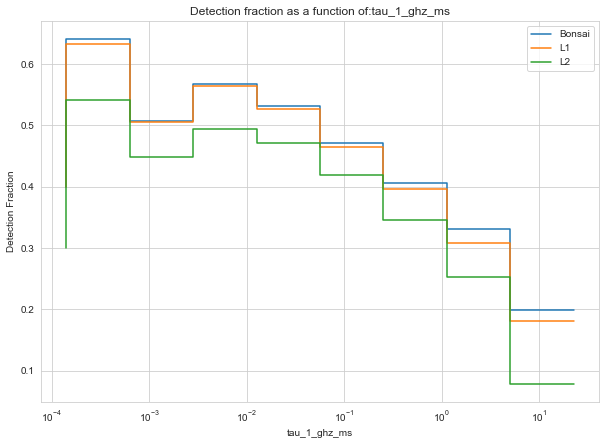

In [22]:
plot_detection_fraction(dm_set1, 5, 8, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(dm_set2, 5, 8, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(dm_set3, 5, 8, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_range= None,  x_log =True)

### 5.2 Detection Fractions with  SNR Segmentation

In [23]:
snr_set1 = injections[injections['combined_snr']<=30]
snr_set2 = injections[injections['combined_snr'].between(30,80)]
snr_set3 = injections[injections['combined_snr']>=80]

#### 5.2.1 DF vs Pulse Width

bins: [1.30456198e-02 3.52399857e-02 9.51933760e-02 2.57144793e-01
 6.94622331e-01 1.87637547e+00 5.06863190e+00 1.36918382e+01
 3.69856082e+01 9.99088063e+01]
Injections Hist: [   24   337  2564  8737 11974  6174  1346   435   385]
Bonsai Hist: [   24   337  2564  8737 11974  6174  1346   435   385]
L1 Hist: [   24   331  2528  8636 11809  6085  1327   420   349]
L2 Hist: [   22   303  2347  7952 10874  5580  1211   313    39]
DF at Bonsai: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
DF at L1: [1.         0.98219585 0.98595944 0.98843997 0.98622014 0.98558471
 0.9858841  0.96551724 0.90649351]
DF at L2 [0.91666667 0.89910979 0.91536661 0.91015223 0.90813429 0.90379009
 0.89970282 0.71954023 0.1012987 ]


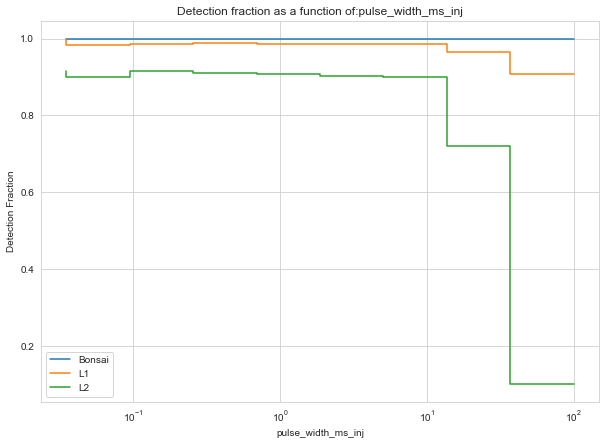

bins: [3.71721010e-02 8.90918674e-02 2.13530057e-01 5.11776063e-01
 1.22659425e+00 2.93982769e+00 7.04600310e+00 1.68874386e+01
 4.04748024e+01 9.70075846e+01]
Injections Hist: [  58  374 1302 2103 1792  620  112   33   55]
Bonsai Hist: [  58  374 1302 2103 1792  620  112   33   55]
L1 Hist: [  58  374 1301 2101 1790  620  112   33   54]
L2 Hist: [  53  343 1204 1922 1626  577  103   29   31]
DF at Bonsai: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
DF at L1: [1.         1.         0.99923195 0.99904898 0.99888393 1.
 1.         1.         0.98181818]
DF at L2 [0.9137931  0.9171123  0.92473118 0.91393248 0.90736607 0.93064516
 0.91964286 0.87878788 0.56363636]


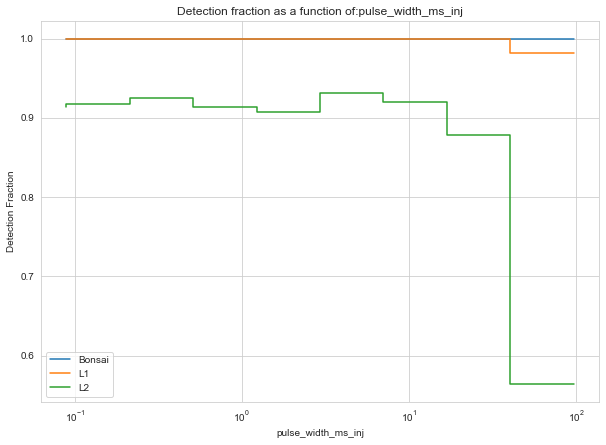

bins: [2.88024143e-02 6.66108796e-02 1.54049908e-01 3.56268742e-01
 8.23936981e-01 1.90550579e+00 4.40683254e+00 1.01916106e+01
 2.35699738e+01 5.45098987e+01]
Injections Hist: [  7  51 171 369 395 184  24   7   2]
Bonsai Hist: [  7  51 171 369 395 184  24   7   2]
L1 Hist: [  7  51 169 368 394 184  24   7   2]
L2 Hist: [  5  37 106 243 273 134  19   6   2]
DF at Bonsai: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
DF at L1: [1.         1.         0.98830409 0.99728997 0.99746835 1.
 1.         1.         1.        ]
DF at L2 [0.71428571 0.7254902  0.61988304 0.65853659 0.69113924 0.72826087
 0.79166667 0.85714286 1.        ]


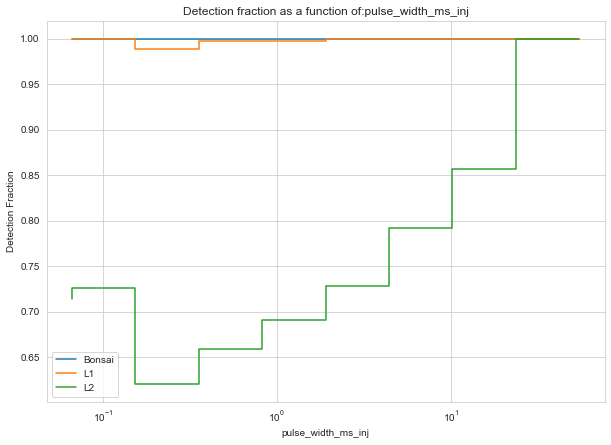

In [24]:
plot_detection_fraction(snr_set1, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(snr_set2, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(snr_set3, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)

##### Analysis:  High SNR injections see significantly lower detection fractions


#### 5.2.2 DF vs Scattering Time

bins: [2.80166000e-05 1.26931284e-04 5.75071596e-04 2.60540451e-03
 1.18039784e-02 5.34787994e-02 2.42289667e-01 1.09771130e+00
 4.97326247e+00 2.25317344e+01]
Injections Hist: [   21   273  1519  5234 10016  9443  4222  1026   221]
Bonsai Hist: [   21   273  1519  5234 10016  9443  4222  1026   221]
L1 Hist: [  21  269 1510 5196 9906 9332 4110  963  201]
L2 Hist: [  18  255 1417 4799 9117 8616 3661  689   68]
DF at Bonsai: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
DF at L1: [1.         0.98534799 0.99407505 0.99273978 0.98901757 0.98824526
 0.97347229 0.93859649 0.90950226]
DF at L2 [0.85714286 0.93406593 0.93285056 0.91688957 0.91024361 0.9124219
 0.86712459 0.67153996 0.30769231]


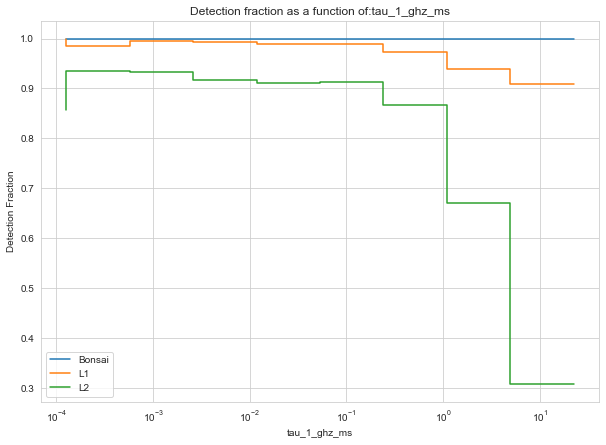

bins: [4.66781000e-05 1.90242757e-04 7.75359465e-04 3.16007983e-03
 1.28793224e-02 5.24913783e-02 2.13935540e-01 8.71922528e-01
 3.55363534e+00 1.44833098e+01]
Injections Hist: [  11   77  383 1170 2026 1796  751  187   48]
Bonsai Hist: [  11   77  383 1170 2026 1796  751  187   48]
L1 Hist: [  11   77  383 1169 2026 1796  749  186   46]
L2 Hist: [  10   69  347 1054 1861 1646  690  176   35]
DF at Bonsai: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
DF at L1: [1.         1.         1.         0.9991453  1.         1.
 0.99733688 0.99465241 0.95833333]
DF at L2 [0.90909091 0.8961039  0.90600522 0.9008547  0.91855874 0.91648107
 0.91877497 0.94117647 0.72916667]


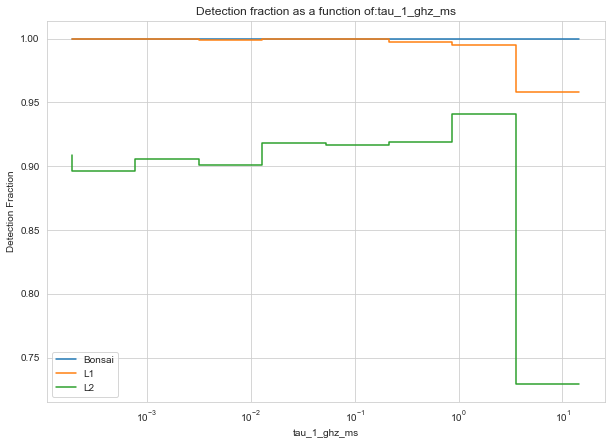

bins: [5.98908000e-05 2.00512732e-04 6.71311046e-04 2.24753070e-03
 7.52467025e-03 2.51923866e-02 8.43434093e-02 2.82379387e-01
 9.45398331e-01 3.16516730e+00]
Injections Hist: [  4  28  61 201 311 368 186  42  11]
Bonsai Hist: [  4  28  61 201 311 368 186  42  11]
L1 Hist: [  4  28  61 200 311 367 185  41  11]
L2 Hist: [  3  24  42 145 208 246 127  24   8]
DF at Bonsai: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
DF at L1: [1.         1.         1.         0.99502488 1.         0.99728261
 0.99462366 0.97619048 1.        ]
DF at L2 [0.75       0.85714286 0.68852459 0.72139303 0.66881029 0.66847826
 0.6827957  0.57142857 0.72727273]


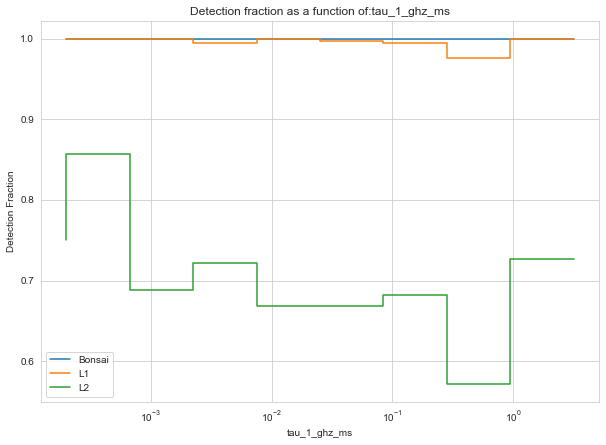

In [25]:
plot_detection_fraction(snr_set1, 5, 8, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(snr_set2, 5, 8, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(snr_set3, 5, 8, x_parameter = 'tau_1_ghz_ms', x_bins= 10, x_range= None,  x_log =True)

### 5.3 DFs with Tree Indices

In [26]:
treeIndex_0 = injections[injections['pulse_width_ms_inj']<1.0]
treeIndex_1 = injections[injections['pulse_width_ms_inj'].between(1.0,2.0)]
treeIndex_2 = injections[injections['pulse_width_ms_inj'].between(2.0,3.0)]
treeIndex_3 = injections[injections['pulse_width_ms_inj'].between(3.0,4.0)]
treeIndex_4 = injections[injections['pulse_width_ms_inj'].between(4.0,5.0)]

bins: [0.00226346 0.00445332 0.00876183 0.01723875 0.03391694 0.06673101
 0.13129213 0.25831505 0.50823049 0.99993491]
Injections Hist: [    0     2     4    45   319  1690  6044 13963 21310]
Bonsai Hist: [    0     0     2    21   145   811  2727  6523 10083]
L1 Hist: [   0    0    2   21  144  800 2695 6456 9980]
L2 Hist: [   0    0    2   19  135  726 2478 5888 9088]
DF at Bonsai: [       nan 0.         0.5        0.46666667 0.45454545 0.47988166
 0.45119126 0.46716322 0.47315814]
DF at L1: [       nan 0.         0.5        0.46666667 0.45141066 0.47337278
 0.44589676 0.46236482 0.46832473]
DF at L2 [       nan 0.         0.5        0.42222222 0.42319749 0.4295858
 0.40999338 0.42168588 0.42646645]


C:\Users\Hp\Desktop\TIFR Internship\codefile.py:273: RuntimeWarning: invalid value encountered in true_divide
  df_bonsai = np.divide(hist_detections, hist_injections)
C:\Users\Hp\Desktop\TIFR Internship\codefile.py:274: RuntimeWarning: invalid value encountered in true_divide
  df_l1 = np.divide(hist_l1, hist_injections)
C:\Users\Hp\Desktop\TIFR Internship\codefile.py:275: RuntimeWarning: invalid value encountered in true_divide
  df_l2 = np.divide(hist_l2, hist_injections)


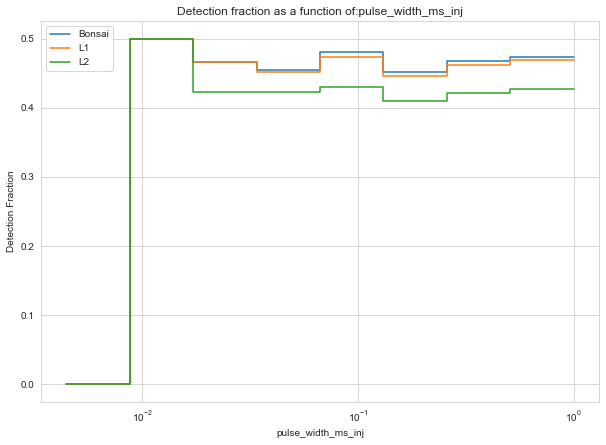

bins: [1.0000649  1.08011074 1.16656349 1.25993598 1.36078206 1.46969992
 1.58733565 1.71438701 1.85160764 1.9998115 ]
Injections Hist: [2510 2475 2491 2474 2368 2268 2195 2058 1926]
Bonsai Hist: [1190 1206 1193 1140 1163 1094 1040  974  904]
L1 Hist: [1180 1193 1171 1135 1155 1081 1027  960  896]
L2 Hist: [1070 1084 1080 1023 1069  982  926  888  826]
DF at Bonsai: [0.47410359 0.48727273 0.47892413 0.46079224 0.49113176 0.48236332
 0.4738041  0.47327502 0.46936656]
DF at L1: [0.47011952 0.4820202  0.47009233 0.45877122 0.48775338 0.47663139
 0.46788155 0.4664723  0.46521288]
DF at L2 [0.42629482 0.4379798  0.43356082 0.4135004  0.45143581 0.4329806
 0.42186788 0.43148688 0.42886812]


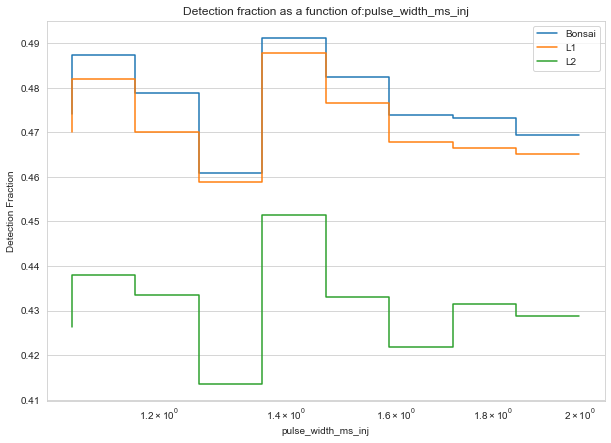

bins: [2.00001247 2.09216931 2.18857257 2.28941791 2.39491002 2.505263
 2.62070085 2.74145785 2.86777911 2.99992103]
Injections Hist: [1127 1078 1033  979  915  883  794  728  764]
Bonsai Hist: [531 535 480 499 442 418 372 334 370]
L1 Hist: [523 527 473 492 434 416 367 331 363]
L2 Hist: [482 479 421 446 396 377 328 300 340]
DF at Bonsai: [0.47116238 0.49628942 0.46466602 0.50970378 0.48306011 0.47338618
 0.46851385 0.45879121 0.48429319]
DF at L1: [0.46406389 0.48886827 0.45788964 0.50255363 0.47431694 0.47112118
 0.46221662 0.45467033 0.47513089]
DF at L2 [0.42768412 0.44434137 0.40755082 0.45556691 0.43278689 0.42695357
 0.41309824 0.41208791 0.44502618]


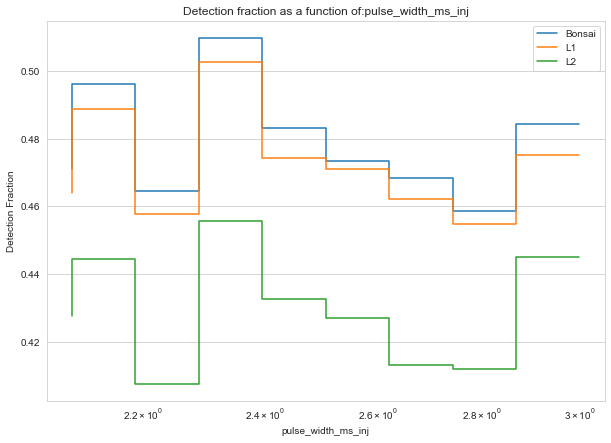

bins: [3.0003782  3.09774606 3.19827369 3.30206362 3.40922173 3.51985733
 3.63408325 3.75201602 3.87377592 3.99948716]
Injections Hist: [535 457 486 442 422 411 353 394 359]
Bonsai Hist: [268 223 212 230 203 196 160 193 167]
L1 Hist: [264 222 210 228 201 195 159 190 167]
L2 Hist: [237 206 188 212 182 182 142 169 148]
DF at Bonsai: [0.50093458 0.48796499 0.43621399 0.52036199 0.48104265 0.47688564
 0.45325779 0.48984772 0.46518106]
DF at L1: [0.49345794 0.48577681 0.43209877 0.5158371  0.47630332 0.47445255
 0.45042493 0.4822335  0.46518106]
DF at L2 [0.44299065 0.45076586 0.38683128 0.47963801 0.43127962 0.44282238
 0.40226629 0.42893401 0.41225627]


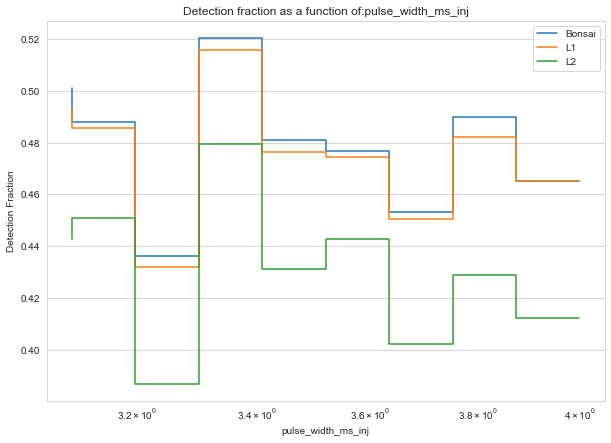

bins: [4.00033628 4.10071656 4.20361568 4.30909684 4.41722484 4.52806609
 4.64168867 4.75816239 4.87755877 4.99995116]
Injections Hist: [265 283 247 271 224 248 234 201 197]
Bonsai Hist: [125 149 109 117 107 121 117  86  89]
L1 Hist: [124 147 108 114 105 119 117  84  87]
L2 Hist: [109 136 100 106  99 109 107  81  79]
DF at Bonsai: [0.47169811 0.52650177 0.44129555 0.43173432 0.47767857 0.48790323
 0.5        0.4278607  0.45177665]
DF at L1: [0.46792453 0.51943463 0.43724696 0.42066421 0.46875    0.47983871
 0.5        0.41791045 0.44162437]
DF at L2 [0.41132075 0.48056537 0.4048583  0.39114391 0.44196429 0.43951613
 0.45726496 0.40298507 0.40101523]


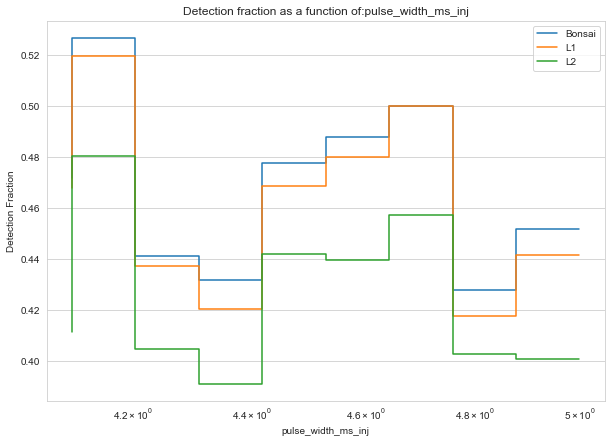

In [27]:
plot_detection_fraction(treeIndex_0, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(treeIndex_1, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(treeIndex_2, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(treeIndex_3, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)
plot_detection_fraction(treeIndex_4, 5, 8, x_parameter = 'pulse_width_ms_inj', x_bins= 10, x_range= None,  x_log =True)